In [1]:
import os
import random
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymysql
import pymongo

In [2]:
# Wait for the databases to be ready.
def wait_for_services():
    time.sleep(10)  # Wait for 10 seconds for the services to start

In [3]:
# MySQL connection.
mysql_conn = pymysql.connect(host='localhost', user='root', password='root')
mysql_cursor = mysql_conn.cursor()

In [4]:
# Create the database if it doesn't exist.
mysql_cursor.execute("CREATE DATABASE IF NOT EXISTS test_db;")
mysql_cursor.execute("USE test_db;")

0

In [5]:
# Create table in MySQL
mysql_cursor.execute("""
    CREATE TABLE IF NOT EXISTS test_table (
        id INT AUTO_INCREMENT PRIMARY KEY,
        name VARCHAR(255),
        country VARCHAR(255)
    );
""")

0

In [6]:
# MongoDB connection
mongo_client = pymongo.MongoClient("mongodb://localhost:27017/")
mongo_db = mongo_client["test_db"]
mongo_collection = mongo_db["test_collection"]

In [7]:
# Create indexes in MongoDB
mongo_collection.create_index([("name", pymongo.TEXT)])  # Full-text index
mongo_collection.create_index([("name", 1)])  # Regular index

'name_1'

In [8]:
# Function to insert data into MySQL.
def insert_data_mysql(data, transactional=True):
    if transactional:
        mysql_conn.begin() # Start transaction.
    sql = "INSERT INTO test_table (name, country) VALUES (%s, %s)"
    mysql_cursor.execute(sql, data)
    if transactional:
        mysql_conn.commit()  # Commit transaction.

In [9]:
# Function to insert data into MongoDB.
def insert_data_mongo(data, transactional=True):
    if transactional:
        mongo_collection.insert_one(data)  # MongoDB does not have explicit transactions for single operations
    else:
        mongo_collection.insert_one(data)

In [10]:
# Function to delete data from MySQL.
def delete_data_mysql(name, transactional=True):
    if transactional:
        mysql_conn.begin()  # Start transaction
    sql = "DELETE FROM test_table WHERE name = %s"
    mysql_cursor.execute(sql, (name,))
    if transactional:
        mysql_conn.commit()  # Commit transaction

In [11]:
# Function to delete data from MongoDB.
def delete_data_mongo(name, transactional=True):
    mongo_collection.delete_one({"name": name})

In [12]:
# Experiment.
results = []
for i in range(100):
    # Generate random data.
    name = f"City_{random.randint(1, 1000)}"
    country = "RU"

    # Insert data with different conditions.
    for index_type in ['FTIDX', 'IDX', 'NOIDX']:
    	for transactional in [True, False]:
        	# Measure insert time.
        	start_time = time.time()
        	if index_type == 'NOIDX':
        		insert_data_mysql((name, country), transactional)
        	else:
        		insert_data_mysql((name, country), transactional)
        	mysql_duration = (time.time() - start_time) * 1000
        	
        	start_time = time.time()
        	insert_data_mongo({"name": name, "country": country}, transactional)
        	mongo_duration = (time.time() - start_time) * 1000
        	
        	# Measure delete time.
        	start_time = time.time()
        	delete_data_mysql(name, transactional)
        	mysql_delete_duration = (time.time() - start_time) * 1000
        	
        	start_time = time.time()
        	delete_data_mongo(name, transactional)
        	mongo_delete_duration = (time.time() - start_time) * 1000
        	
        	# Store results.
        	results.append({
        		"Index Type": index_type,
        		"Transaction": "TX" if transactional else "NOTX",
        		"MySQL Insert Time (ms)": mysql_duration,
        		"MongoDB Insert Time (ms)": mongo_duration,
        		"MySQL Delete Time (ms)": mysql_delete_duration,
        		"MongoDB Delete Time (ms)": mongo_delete_duration
        	})

In [13]:
# Convert results to Pandas' DataFrame.
results_df = pd.DataFrame(results)
results_df.head

<bound method NDFrame.head of     Index Type Transaction  MySQL Insert Time (ms)  MongoDB Insert Time (ms)  \
0        FTIDX          TX               15.826941                 10.812044   
1        FTIDX        NOTX                0.611067                  1.032591   
2          IDX          TX               22.533178                  1.730442   
3          IDX        NOTX                1.279593                  1.698494   
4        NOIDX          TX               20.679712                  2.137661   
..         ...         ...                     ...                       ...   
595      FTIDX        NOTX                0.645638                  1.131535   
596        IDX          TX               19.919634                  1.410007   
597        IDX        NOTX                0.689745                  1.253843   
598      NOIDX          TX               15.189648                  1.739025   
599      NOIDX        NOTX                0.700712                  1.151323   

     MySQ

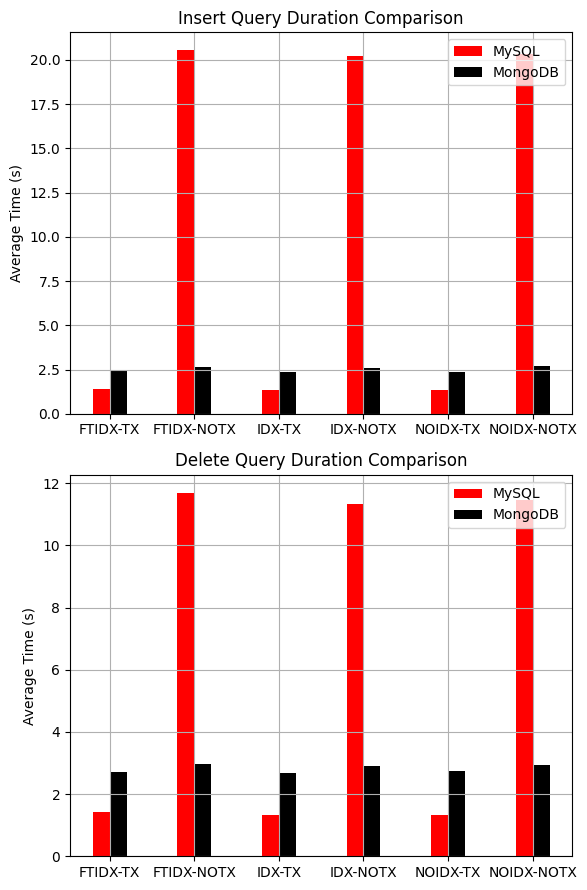

In [16]:
# Create a new column for combined labels
results_df['Label'] = results_df['Index Type'] + '-' + results_df['Transaction']

# Set the bar width
bar_width = 0.2

# Create subplots for each query type
fig, axs = plt.subplots(2, 1, figsize=(6, 9))

# Define query types and their corresponding column names
query_types = ['Insert', 'Delete']
mysql_columns = ['MySQL Insert Time (ms)', 'MySQL Delete Time (ms)']
mongo_columns = ['MongoDB Insert Time (ms)', 'MongoDB Delete Time (ms)']

# Loop through each query type and create a bar plot.
for i, query in enumerate(query_types):
    # Set the positions of the bars on the x-axis.
    x = np.arange(len(results_df['Label'].unique()))
    
    # Plot MySQL and MongoDB times for the current query type.
    axs[i].bar(x - bar_width/2, 
               results_df.groupby('Label')[mysql_columns[i]].mean(), 
               width=bar_width, 
               label='MySQL', color='red')
    
    axs[i].bar(x + bar_width/2, 
               results_df.groupby('Label')[mongo_columns[i]].mean(), 
               width=bar_width, 
               label='MongoDB', color='black')
    
    # Set the x-ticks and labels
    axs[i].set_xticks(x)
    axs[i].set_xticklabels(results_df['Label'].unique())
    axs[i].set_title(f'{query} Query Duration Comparison')
    axs[i].set_ylabel('Average Time (s)')
    axs[i].legend()
    axs[i].grid()

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

In [15]:
# Close connections.
# TODO: Uncommet all commands.
# mysql_cursor.close()
# mysql_conn.close()
# mongo_client.close()